In [1]:
import numpy as np


## Import Metastatic Tissue Dataset

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset
import h5py
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt 
import torchvision
import torchvision.transforms as transforms
from PIL import Image

In [3]:
def load_data(filename):
    with h5py.File(filename, "r") as f:
        # List all groups
        a_group_key = list(f.keys())[0]

        # Get the data
        data = torch.from_numpy(f[a_group_key][:])
        print(data.shape)
        return data
    
training_images = load_data("./pcam/training_split.h5")
print(training_images.shape)


validation_split = load_data("./pcam/validation_split.h5")
test_split = load_data("./pcam/test_split.h5")

validation_labels = load_data("./Labels/Labels/camelyonpatch_level_2_split_valid_y.h5").squeeze().type(torch.LongTensor)
testing_labels = load_data("./Labels/Labels/camelyonpatch_level_2_split_test_y.h5").squeeze().type(torch.LongTensor)
training_labels = load_data("./Labels/Labels/camelyonpatch_level_2_split_train_y.h5").squeeze().type(torch.LongTensor)
print(training_labels.shape)

torch.Size([262144, 96, 96, 3])
torch.Size([262144, 96, 96, 3])
torch.Size([32768, 96, 96, 3])
torch.Size([32768, 96, 96, 3])
torch.Size([32768, 1, 1, 1])
torch.Size([32768, 1, 1, 1])
torch.Size([262144, 1, 1, 1])
torch.Size([262144])


In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, image, labels):
        self.labels = labels
        self.image = image
    def __len__(self):
            return len(self.labels)
    def __getitem__(self, index):
            label = self.labels[index]
            images = self.image[index]
            sample = {"Image": images, "Label": label}
            return (images,label)

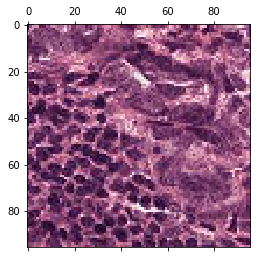

In [5]:
plt.matshow(training_images[56])

In [22]:
print(training_labels[56].item())

1


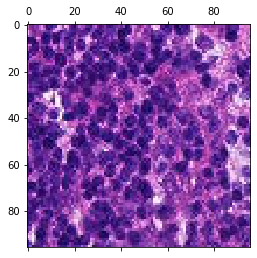

In [23]:
plt.matshow(training_images[6])

In [24]:
print(training_labels[6].item())

0


In [6]:
training_images = training_images .permute((0,3,1,2)).type(torch.FloatTensor)
print(training_images.shape)
validation_split = validation_split.permute((0,3,1,2)).type(torch.FloatTensor)
test_split = test_split.permute((0,3,1,2)).type(torch.FloatTensor)

torch.Size([262144, 3, 96, 96])


In [7]:
print(validation_split.shape)
print(test_split.shape)

torch.Size([32768, 3, 96, 96])
torch.Size([32768, 3, 96, 96])


In [8]:
TrainingData = CustomImageDataset(training_images ,training_labels)
TestData = CustomImageDataset(test_split,testing_labels)
ValData = CustomImageDataset(validation_split,validation_labels)

In [9]:
class TissueCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=10, kernel_size = (4,4)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4), stride = 2),
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size = (4,4)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4), stride = 2),
            nn.Conv2d(in_channels=20, out_channels=30, kernel_size = (4,4)),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Flatten(1),
            nn.Linear(8670, 1),
            nn.Sigmoid(),
#             nn.Softmax()
        )
#         self.convd = nn.Conv2d(in_channels=3, out_channels=1, kernel_size = (4,4))
#         self.maxPool = nn.MaxPool2d(kernel_size = (2,2), stride = 1)
#         self.Relu = nn.ReLU()
#         self.flatten = nn.Flatten()
#         self.linear = nn.Linear(8464, 2)
#         self.soft = nn.Softmax()

    def forward(self, x):
#         out = self.convd(x)
# #         print(out.shape)
#         out = self.maxPool(out)
# #         print(out.shape)
#         out = self.Relu(out)
# #         print(out.shape)
#         out = self.flatten(out)
# #         print(out.shape)
#         out = self.linear(out)
# #         print(out.shape)
#         out = self.soft(out)
# #         print(out.shape)
        return self.layers(x)

### Data Cleaning

In [10]:
model = TissueCNN()
print(model)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

##Doing batching
batch_size = 64
train_loader = torch.utils.data.DataLoader(TrainingData, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(TestData, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(ValData, batch_size, shuffle=True)

TissueCNN(
  (layers): Sequential(
    (0): Conv2d(3, 10, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(10, 20, kernel_size=(4, 4), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(20, 30, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=8670, out_features=1, bias=True)
    (11): Sigmoid()
  )
)


In [14]:
def train_network(model, train_loader, val_loader, criterion, optimizer, nepoch=100):
    try:
        train_iter = iter(train_loader)
        total_loss = 0
        for epoch in tqdm(range(500)):
            inputs, labels = next(train_iter)
            optimizer.zero_grad()
            #print("input ", inputs.shape)
            outputs = model(inputs)
            outputs = outputs.squeeze()
#                 print("outputs ", outputs)
#                 print("labels ", labels)
            loss = criterion(outputs, labels.type(torch.FloatTensor))
            #print("loss before ", loss.item())
            #print("back")
            loss.backward()
            optimizer.step()
            #print("loss after ", loss.item())
            total_loss += loss.item()
            if not epoch % 100:
                print("EPOCH", epoch)
                print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/(epoch + 1)))
                with torch.no_grad():
                    correct = 0
                    total = 0
                    total_loss = 0
                    true, pred = [], []
                    val_iterator = iter(val_loader)
                    # validate with first 10 batches from validation set
                    for i in range(10):
                        outputs = model(inputs)
                        predicted = (outputs > .5).float().squeeze()
                        total += labels.size(0)
                        total_loss += criterion(outputs.squeeze(), labels.type(torch.FloatTensor))
                        correct += (predicted == labels).sum().item()
                        true.append(labels)
                        pred.append(predicted) 
                    print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/10))
                    val_accuracy = (100 * correct / total)
                    print('Val accuracy: %0.3f' % (100 * correct / total))
                    
                    print()
                
        with torch.no_grad():
            correct = 0
            total = 0
            true, pred = [], []
            for inputs, labels in test_loader:
                outputs = model(inputs)
                predicted = (outputs > .5).float().squeeze()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                true.append(labels)
                pred.append(predicted) 
            print('Test accuracy: %0.3f' % (100 * correct / total))
    except KeyboardInterrupt:
        print('Exiting from training early')
    return

In [15]:
def test_network(model, test_loader):
    with torch.no_grad():
        correct = 0
        total = 0
        true, pred = [], []
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs > .5).float().squeeze()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true.append(labels)
            pred.append(predicted) 
        print('Test accuracy: %0.3f' % (100 * correct / total))

In [ ]:
train_network(model, train_loader, val_loader, criterion, optimizer)


  0%|          | 0/500 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.09983
   Val loss: 1.13129
Val accuracy: 50.938

EPOCH 100
 Train loss: 0.74536
   Val loss: 0.53600
Val accuracy: 73.438

EPOCH 200
 Train loss: 0.28595
   Val loss: 0.51436
Val accuracy: 74.531

EPOCH 300
 Train loss: 0.18891
   Val loss: 0.44490
Val accuracy: 78.438

EPOCH 400
 Train loss: 0.13995
   Val loss: 0.36012
Val accuracy: 83.125



In [ ]:
train_network(model, train_loader, val_loader, criterion, optimizer)

In [29]:
test_network(model, test_loader)

Test accuracy: 76.337


COMPUTATIONAL EXPERIMENT ONE

In [17]:
gray = []
i = 0
for image in training_images[:50000]:
    imgg = torchvision.transforms.Grayscale()(image)
    gray.append(imgg)
    if i % 5000 == 0:
        print(i)
    i += 1

0
5000
10000
15000
20000
25000
30000
35000
40000
45000


In [18]:
gray[0].shape


torch.Size([1, 96, 96])

In [22]:
a = np.asarray(gray)
a.shape


(50000,)

In [20]:

class TissueCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.l1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size = (4,4))
        self.l2 =   nn.ReLU()
        self.l3 =  nn.MaxPool2d(kernel_size = (4,4), stride = 2)
        self.l4  =  nn.Conv2d(in_channels=10, out_channels=20, kernel_size = (4,4))
        self.l5  =  nn.ReLU()
        self.l6 =   nn.MaxPool2d(kernel_size = (4,4), stride = 2)
        self.l7 =    nn.Conv2d(in_channels=20, out_channels=30, kernel_size = (4,4))
        self.l8 =  nn.ReLU()
        self.l9 =  nn.Dropout(0.25)
        self.l10 =  nn.Flatten(1)
        self.l11=  nn.Linear(8670, 1)
        self.l12=  nn.Sigmoid()
        


    def forward(self, x):
        #print(x.shape)
        out = self.l1(x)
        #print(out.shape)
        out = self.l2(out)
        #print(out.shape)
        out = self.l3(out)
        #print(out.shape)
        out = self.l4(out)
        #print(out.shape)
        out = self.l5(out)
        #print(out.shape)
        out = self.l6(out)
        #print(out.shape)
        out = self.l7(out)
        #print(out.shape)
        out = self.l8(out)
        #print(out.shape)
        out = self.l9(out)
        #print(out.shape)
        out = self.l10(out)
        #print(out.shape)
        out = self.l11(out)
        #print(out.shape)
        out = self.l12(out)
        #print(out.shape)
        return out
        

In [23]:
TrainingData = CustomImageDataset(a ,training_labels[:50000])
TestData = CustomImageDataset(test_split[:5000],testing_labels[:5000])
ValData = CustomImageDataset(validation_split[:5000],validation_labels[:5000])



In [28]:
model = TissueCNN()
print(model)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

##Doing batching
batch_size = 64
train_loader = torch.utils.data.DataLoader(TrainingData, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(TestData, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(ValData, batch_size, shuffle=True)

TissueCNN(
  (l1): Conv2d(1, 10, kernel_size=(4, 4), stride=(1, 1))
  (l2): ReLU()
  (l3): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (l4): Conv2d(10, 20, kernel_size=(4, 4), stride=(1, 1))
  (l5): ReLU()
  (l6): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (l7): Conv2d(20, 30, kernel_size=(4, 4), stride=(1, 1))
  (l8): ReLU()
  (l9): Dropout(p=0.25, inplace=False)
  (l10): Flatten(start_dim=1, end_dim=-1)
  (l11): Linear(in_features=8670, out_features=1, bias=True)
  (l12): Sigmoid()
)


In [29]:
train_network(model, train_loader, val_loader, criterion, optimizer)



  0%|          | 0/1000 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.66342
   Val loss: 2.15355
Val accuracy: 45.781

EPOCH 100
 Train loss: 0.99935
   Val loss: 0.57979
Val accuracy: 70.781

EPOCH 200
 Train loss: 0.30894
   Val loss: 0.48177
Val accuracy: 79.688

EPOCH 300
 Train loss: 0.19596
   Val loss: 0.52262
Val accuracy: 81.250

EPOCH 400
 Train loss: 0.14508
   Val loss: 0.57842
Val accuracy: 71.562

EPOCH 500
 Train loss: 0.11619
   Val loss: 0.55007
Val accuracy: 72.188

EPOCH 600
 Train loss: 0.09472
   Val loss: 0.47443
Val accuracy: 80.625

EPOCH 700
 Train loss: 0.07968
   Val loss: 0.39944
Val accuracy: 88.281



StopIteration: 

COMPUTATIONAL EXPERIMENT TWO